## Training an image classifier

我们会遵照一下几个步骤：

- 使用torchvision加载标准化的CIFAR10 训练集和测试集
- 定义卷积神经网络
- 定义Loss
- 在训练集上训练网络
- 在测试集上测试网络

### 加载数据
使用`torchvision`很放方便的加载CIFAR10

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

`torchvision`数据集输出的是PILImage格式的图片，像素范围在[0,1].我们将其转为Tensor，值为[-1,1]

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


找几张图片看看

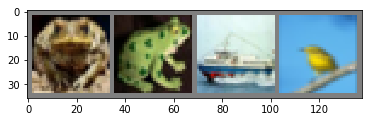

 frog  frog  ship  bird


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # 转换通道 C,H,W --> H,W,C
    plt.show() # 注意原文档没有show，无法显示图片

# 使用一个迭代器获取一些图片
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images)) # 使用make_grid将几张图片合并到一个网格图片中
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### 定义卷积神经网络
使用上一节用过的LeNet，将通道1改成3

In [4]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # 修改通道
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### 定义Loss
使用交叉熵和带动量的SGD

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 训练网络

In [6]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad() # 清空梯度

        # forward + backward + optimize
        outputs = net(inputs) #传入数据获得预测值
        loss = criterion(outputs, labels) # 计算loss
        loss.backward()   # 反向传播
        optimizer.step() # 更新参数

        # print statistics
        running_loss += loss.data[0]
        if i % 2000 == 1999:    # 每2000个mini-batches查看一下loss
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.239
[1,  4000] loss: 1.872
[1,  6000] loss: 1.689
[1,  8000] loss: 1.587
[1, 10000] loss: 1.536
[1, 12000] loss: 1.473
[2,  2000] loss: 1.391
[2,  4000] loss: 1.373
[2,  6000] loss: 1.336
[2,  8000] loss: 1.305
[2, 10000] loss: 1.305
[2, 12000] loss: 1.264
Finished Training


### 在测试集上测试模型
上面已经在训练集上训练了2个epoch,下面看看模型在测试集上表现。同样的，先看看测试集图片。

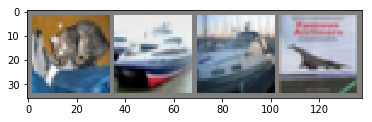

GroundTruth:    cat  ship  ship plane


In [7]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [8]:
outputs = net(Variable(images))
print(outputs.shape)

torch.Size([4, 10])


模型的输出是4个输出关于10个类别的概率值，我们找出概率最大的~

In [9]:
_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   ship   car  ship  ship


结果错了一个，还算可以吧。可以看看模型在整个测试集上的表现：

In [10]:
correct = 0
total = 0
for data in testloader: # 迭代整个测试集
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


测试各个类别的表现：

In [11]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze() 
    
    for i in range(4): # 每个batch是4
        label = labels[i]
        class_correct[label] += c[i] # 统计每个种类预测对的
        class_total[label] += 1  # 终极每个种类一共有多少个

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 57 %
Accuracy of   car : 75 %
Accuracy of  bird : 51 %
Accuracy of   cat : 13 %
Accuracy of  deer : 53 %
Accuracy of   dog : 33 %
Accuracy of  frog : 82 %
Accuracy of horse : 68 %
Accuracy of  ship : 69 %
Accuracy of truck : 45 %
